In [13]:
import numpy as np
import pandas as pd 
import lightgbm as lg
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

import re

import warnings
warnings.filterwarnings('ignore')

from collections import defaultdict

In [2]:
def load():
    train = pd.read_csv('./train.tsv', sep='\t').iloc[:, 1:]
    test  = pd.read_csv('./test.tsv', sep='\t').iloc[:, 1:]
    return train, test

def loss(acc):
    if acc <= 0.5: 
        return 0
    else:
        return 1 + 6 * (acc - 0.5)

In [3]:
# simple delta classifier, baseline

train, test = load()
# delta: киллер-фича! (нет)
train['delta_lat'] = np.abs(train.user_lat - train.lat)
train['delta_lon'] = np.abs(train.user_lon - train.lon)


X = []
for group in train.groupby('group_num'):
    X.append(group[1])

acc = 0
for g in X:
    target = np.where(g.target)[0][0]
    prediction = np.argmin(g.delta_lat.values + g.delta_lon.values)
    if target == prediction: 
        acc += 1
        
acc /= len(X)
acc, loss(acc)

(0.372952380952381, 0)

In [4]:
def str_len(s):
    return len(s)

def str_parts(s, sep=','):
    return len(s.split(sep))

def list_len(s, sep='", "'):
    return len(re.sub("[\[\]]", "", s).strip('"').split(sep))

def calc_group_index(df, f):
    group_mean = df.groupby('group_num')[f].mean().rename(f+'_mean').reset_index()
    df[f+'_group_index'] = df[f] / df.merge(how='left', on='group_num', 
                                            right=group_mean)[f+'_mean']
    #print(df.groupby('target').mean()[f])
    #print(df.groupby('target').mean()[f+'_group_index'])
    
def lst0(s, sep='", "'):
    l = re.sub("[\[\]]", "", s).strip('"').split(sep)
    return l[0]


In [43]:
def feval(y_hat, y_true):
    groups = feval_train.values if y_true.params['train'] else feval_test.values
    targets = y_true.get_label()
    max_pred = defaultdict(lambda: (-1, -1))
    n = len(y_hat)
    for i in range(n):
        if max_pred[groups[i]][0] < y_hat[i]:
            max_pred[groups[i]] = (y_hat[i], i)
    acc = 0
    for _, i in max_pred.values():
        acc += targets[i]
    acc /= len(max_pred)
    return 'score', 1 + 6 * (acc - 0.5), True

In [44]:
def preprocessing(train, test):

    # names
    for df in [train, test]:
        df['name_len_lst'] = df.names.apply(list_len)
        df = calc_group_index(df, 'name_len_lst')
    stat_feat = ['name_len_lst_group_index']
       
    # merge 
    y = train.target.values
    train['train'] = 1
    test['train'] = 0

    data = pd.concat([train.drop(['target'], 1), test])
    # delta
    data['delta_lat'] = np.abs(data.user_lat - data.lat)
    data['delta_lon'] = np.abs(data.user_lon - data.lon)
    
    # rubrics
    data['rubrics0'] = data.rubrics.apply(lambda x: lst0(x, sep=',')).astype(int)
    top_rubr = data.rubrics0.value_counts()
    top_rubr = top_rubr[top_rubr > 10].index
    data.rubrics0[~np.isin(data.rubrics0, top_rubr)] = -1
    
    # ssid 
    
    
    # features
    features = {}
    features['cat'] = ['has_wifi', 'publishing_status', 'rubrics0']
    features['num'] = ['delta_lat', 'delta_lon'] + stat_feat
    features['all'] = features['cat'] + features['num']
    
    # cat factorize
    le = LabelEncoder()
    data['publishing_status'] = le.fit_transform(data.publishing_status)
    data['rubrics0'] = le.fit_transform(data.rubrics0)
    data['has_wifi'] = data.has_wifi.fillna(-1).astype(int)
    data['rubrics0'] = data.rubrics0.fillna(-1).astype(int)
    
    return data, y, features


In [45]:
# train

train, test = load()
data, y, features = preprocessing(train, test)

X = data[data.train == 1][features['all']+['group_num']]
groups = X.group_num
train_groups = X.group_num < 4000
feval_train = X.group_num[train_groups]
feval_test = X.group_num[~train_groups]
X.drop(['group_num'], 1, inplace=True)

X_train, X_test = X[train_groups], X[~train_groups]
y_train, y_test = y[train_groups], y[~train_groups]

In [49]:
dstrain = lg.Dataset(X_train, y_train, feature_name=features['all'], 
                     categorical_feature=features['cat'], params={'train': 1})
dstest = lg.Dataset(X_test, y_test, feature_name=features['all'], 
                    categorical_feature=features['cat'], params={'train': 0})

lg_params = {
    'objective': 'binary', 
    #'scale_pos_weight': 20,
    #'is_unbalance': True,
    'n_estimators': 120, 
    'max_depth': 3, 
    'num_leaves': 7,
    'subsamle': 0.9,
    'subsample_freq': 1, 
    'feature_fraction': 0.9
}

model = lg.train(lg_params, dstrain, valid_sets=[dstrain, dstest], 
                 feval=feval, verbose_eval=20)

[20]	training's binary_logloss: 0.165336	training's score: 1.9255	valid_1's binary_logloss: 0.183628	valid_1's score: 1.792
[40]	training's binary_logloss: 0.108086	training's score: 2.3515	valid_1's binary_logloss: 0.128405	valid_1's score: 2.1568
[60]	training's binary_logloss: 0.0957319	training's score: 2.434	valid_1's binary_logloss: 0.116762	valid_1's score: 2.2192
[80]	training's binary_logloss: 0.0912138	training's score: 2.4745	valid_1's binary_logloss: 0.112827	valid_1's score: 2.2624
[100]	training's binary_logloss: 0.0884359	training's score: 2.5075	valid_1's binary_logloss: 0.111003	valid_1's score: 2.3008
[120]	training's binary_logloss: 0.0867447	training's score: 2.518	valid_1's binary_logloss: 0.109743	valid_1's score: 2.3152


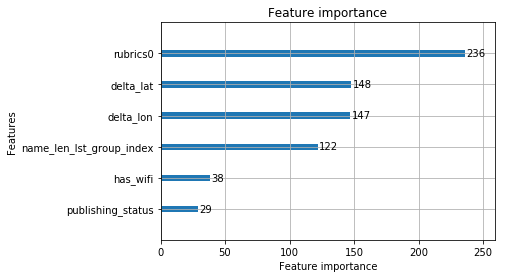

In [50]:
%matplotlib inline
lg.plot_importance(model)

In [12]:
# train accuracy check 

test_pred = model.predict(X_test)
test_groups = groups[groups >= 4000]
test_acc = 0
for i in np.unique(test_groups):
    idx = np.where(test_groups==i)[0]
    target = np.where(y_test[idx])[0][0]
    pred = np.argmax(test_pred[idx])
    if target == pred: 
        test_acc += 1
test_acc /= len(np.unique(test_groups))
test_acc, loss(test_acc)

(0.7168, 2.3007999999999997)

In [13]:
# train on full data 
dstrain = lg.Dataset(X, y, feature_name=features['all'], categorical_feature=features['cat'])
model = lg.train(lg_params, dstrain)

In [14]:
def predict(test, groups, model):
    pred = model.predict(test)
    output = []
    for i in np.unique(groups):
        g = groups==i
        g_output = [0] * g.sum()
        g_output[np.argmax(pred[g])] = 1
        output += g_output
    return output

In [15]:
# pipeline, public score = 2.61

train, test = load()
data, y, features = preprocessing(train, test)
test = data[data.train == 0][features['all']+['group_num']]

# predict 
groups = test.group_num
test.drop(['group_num'], 1, inplace=True)
output = predict(test, groups, model)

# write 
pd.DataFrame(output).to_csv('target.tsv', sep='\t', index=False, header=False)